# Main script that generating most of the desired outputs
Can be computationally heavy at the latter end of the script

In [29]:
# Add local scripts to module search path
import sys
import os

from pathlib import Path
path = str(Path().resolve())
sys.path.append((path[0:len(path)-len("notebooks/TinyTol")]) + "toliman-proper")

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

from astropy.coordinates import SkyCoord

import proper
proper.print_it = False

from prescription_quad import prescription_quad
from proper_tools import form_detector_image
from spirals import binarized_ringed_flipped

def binarized_ringed_650_scaled(r, phi, r_max=20., r_min=0., r_split=15):
    phase = 650.*1e-9*0.5 # Has units of nm
    return binarized_ringed_flipped(r, phi, phase, r_max=r_max, r_min=r_min, r_split=r_split)

def binarized_ringed_600_scaled(r, phi, r_max=20., r_min=0., r_split=15):
    phase = 600.*1e-9*0.5 # Has units of nm
    return binarized_ringed_flipped(r, phi, phase, r_max=r_max, r_min=r_min, r_split=r_split)

def binarized_ringed_525_scaled(r, phi, r_max=20., r_min=0., r_split=15):
    phase = 525.*1e-9*0.5 # Has units of nm
    return binarized_ringed_flipped(r, phi, phase, r_max=r_max, r_min=r_min, r_split=r_split)

##15mm apperture
# find ideal pupil design for single wavelength centred on the green wavelegnth

In [30]:
from spectrum_generator import get_spec, get_counts
from FT_model import model_FT
from Bayer import get_red, get_green, get_blue
from get_wf import get_wf

In [31]:
prescription = 'prescription_quad'

### 
image_path = "Images/"
# Add path the where images should be saved, ie "User/louis/desktop"
###

#### Put in our simple tinytol settings and simulate a single wavelength no diffractive pupil

In [32]:
fl = 0.15 # Focal length
app = 0.02 # Apperture (m)
detector_pitch = 1.12e-6 # m/pixel on detector (pixel spacing)
spiral = binarized_ringed_525_scaled # Spiral function to be run
gridsize = 2048 # size of the grid that the simulation is run on
npixels = 1024 # Size of detector, in pixels
ratio = 0.5 # ratio  of gridsize to appreture size (ignore)

In [33]:
tinytol_settings = {
                    'diam': app,                # telescope diameter in meters
                    'm1_fl': fl,                # primary focal length (m)
                    'beam_ratio': ratio,        # Initial beam width/grid width
                    }   

In [34]:
wl_vals = [0.525]    # Wavelength values (micrometers)
wl_weights = [1.]    # Wavelength relative intensities

In [35]:
source = {
            'wavelengths': wl_vals,
            'weights': wl_weights,
            'settings': tinytol_settings
            }

sources = [source]

In [36]:
%%time
image = form_detector_image(prescription, sources, gridsize, detector_pitch, npixels)

no phase function
CPU times: user 1.48 s, sys: 242 ms, total: 1.72 s
Wall time: 3.09 s


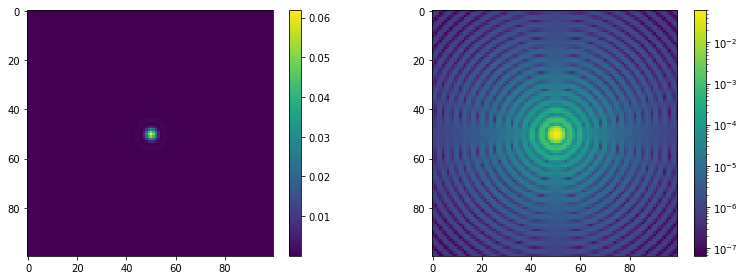

In [37]:
size = 100
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

c = image.shape[0]/2
im_out = image[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
im_out = im_out/np.sum(im_out)

im = axs[0].imshow(im_out)
plt.colorbar(im,ax=axs[0],fraction=0.046, pad=0.04)
    
im = axs[1].imshow(im_out,norm=LogNorm())
plt.colorbar(im,ax=axs[1],fraction=0.046, pad=0.04)
fig.tight_layout()
# fig.savefig(image_path + "no_pupil_grouped.jpg", bbox_inches='tight')

#### Add the diffractive pupil and simulate a single wavelength

In [38]:
tinytol_settings['opd_func'] = spiral # Phase function applied to appreture

In [39]:
%%time
image = form_detector_image(prescription, sources, gridsize, detector_pitch, npixels)

CPU times: user 1.52 s, sys: 459 ms, total: 1.98 s
Wall time: 8.26 s


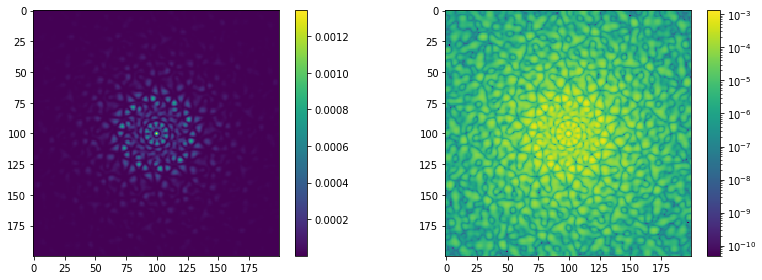

In [40]:
size = 200
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

c = image.shape[0]/2
im_out = image[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
im_out = im_out/np.sum(im_out)

im = axs[0].imshow(im_out)
plt.colorbar(im,ax=axs[0],fraction=0.046, pad=0.04)
    
im = axs[1].imshow(im_out,norm=LogNorm())
plt.colorbar(im,ax=axs[1],fraction=0.046, pad=0.04)
fig.tight_layout()
# fig.savefig(image_path + "simple_pupil_grouped.jpg", bbox_inches='tight')

#### Look at the phase pupil being applied to the system, and compare results to Fourier transforms

In [41]:
%%time

tinytol_settings['get_wf'] = True
tinytol_settings['beam_ratio'] = 0.99
wfo, wf, sampling = prescription_quad(wl_vals[0]*1e-6,gridsize,PASSVALUE=tinytol_settings)

Got wavefront
CPU times: user 7.99 s, sys: 216 ms, total: 8.21 s
Wall time: 7.89 s


In [42]:
tinytol_settings['get_wf'] = False
tinytol_settings['beam_ratio'] = ratio

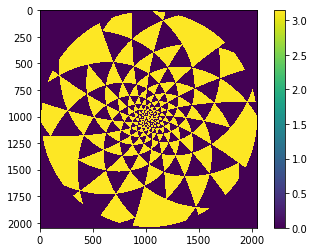

In [43]:
plt.imshow(np.abs(np.angle(wf)))#,cmap='prism')
plt.colorbar()
# plt.savefig(image_path + "phase.jpg", bbox_inches='tight')
plt.show()

#### Now see how these results compare to a simulation with Fourier Transforms

In [44]:
%%time

mask = wf
mask_size = tinytol_settings['diam']
chip_dim = npixels
foc_length = tinytol_settings['m1_fl']
pix_size = detector_pitch

image = model_FT(mask, mask_size, chip_dim, [wl_vals[0]*1e-6], foc_length, pix_size)

CPU times: user 5.6 s, sys: 2.1 s, total: 7.7 s
Wall time: 6.14 s


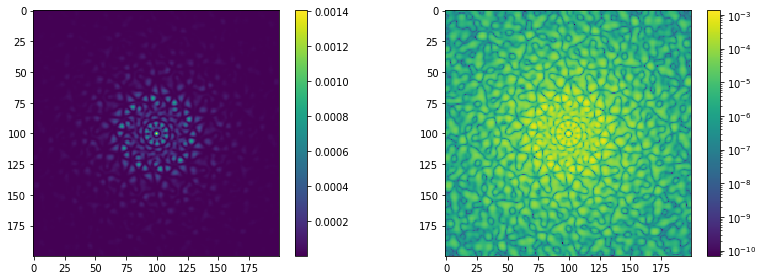

In [45]:
size = 200
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

c = image.shape[0]/2
im_out = image[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
im_out = im_out/np.sum(im_out)

im = axs[0].imshow(im_out)
plt.colorbar(im,ax=axs[0],fraction=0.046, pad=0.04)
    
im = axs[1].imshow(im_out,norm=LogNorm())
plt.colorbar(im,ax=axs[1],fraction=0.046, pad=0.04)
fig.tight_layout()
# fig.savefig(image_path + "simple_pupil_FT_grouped.jpg", bbox_inches='tight')

#### Test that we do infact observe a ~3" per pixel ratio in our formed image

##### Should see the star at the outer limit at tilt of 795" (256*3 = 795)

In [46]:
# tinytol_settings['tilt_x'] = 795

In [47]:
# %%time
# image = form_detector_image(prescription, sources, gridsize, detector_pitch, npixels)

In [48]:
# im_out = image
# im_out = im_out/np.sum(im_out)

# plt.imshow(im_out)
# plt.colorbar()
# # plt.savefig(image_path + "proper.jpg", bbox_inches='tight')

# plt.show()

# plt.imshow(im_out,norm=LogNorm())
# plt.savefig(image_path + "pixel_test.jpg", bbox_inches='tight')
# # plt.colorbar()
# plt.show()

#### See how this compares to FT version

In [49]:
# tinytol_settings['get_wf'] = True
# tinytol_settings['beam_ratio'] = 0.99
# tinytol_settings['tilt_x'] = 150

# mask_size = tinytol_settings['diam']
# chip_dim = npixels
# foc_length = tinytol_settings['m1_fl']
# pix_size = detector_pitch
# samples = 5

# spec = get_spec("MizarA", "red", samples=5, microns=True)
# wavelengths = spec[0][0]
# image = np.zeros((chip_dim,chip_dim))

# %%time

# for wavelength in wavelengths:
#     wfo, wf, sampling = prescription_quad(wavelength*1e-6,gridsize,PASSVALUE=tinytol_settings)
#     mask = wf
#     image += model_FT(wf, mask_size, chip_dim, [wavelength*1e-6], foc_length, pix_size)
    
# tinytol_settings['tilt_x'] = 0
# tinytol_settings['get_wf'] = False
# tinytol_settings['beam_ratio'] = 0.5

# im_out = image
# im_out = im_out/np.sum(im_out)
# im_out = im_out[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]


# plt.imshow(im_out)
# plt.colorbar()
# plt.show()

# plt.imshow(im_out,norm=LogNorm())
# # plt.savefig(image_path + "FT_pixel_test.jpg", bbox_inches='tight')
# plt.colorbar()
# plt.show()

In [50]:
# %%time
# image = model_FT(wf, mask_size, chip_dim, [wl_vals[0]*1e-6], foc_length, pix_size)

In [51]:
# im_out = image
# im_out = im_out/np.sum(im_out)

# plt.imshow(im_out)
# plt.colorbar()
# plt.show()

# plt.imshow(im_out,norm=LogNorm())
# plt.savefig(image_path + "FT_pixel_test.jpg", bbox_inches='tight')
# # plt.colorbar()
# plt.show()

#### Now import our generated spectrum and run the simulation across our different wavelength bands

In [28]:
%%time

tinytol_settings['tilt_x'] = -0.00

# samples = 15
samples = 3
stars = ["MizarA"]
colours = ["red","green","blue"]
RGB_images = []

for colour in colours:
    spec = get_spec(stars, colour, samples, microns=True)
    sources[0]['wavelengths'] = spec[0][0]
    sources[0]['weights'] = spec[0][1]

    image = form_detector_image(prescription, sources, gridsize, detector_pitch, npixels)
    RGB_images.append(image)

CPU times: user 12.5 s, sys: 2.03 s, total: 14.5 s
Wall time: 42.6 s


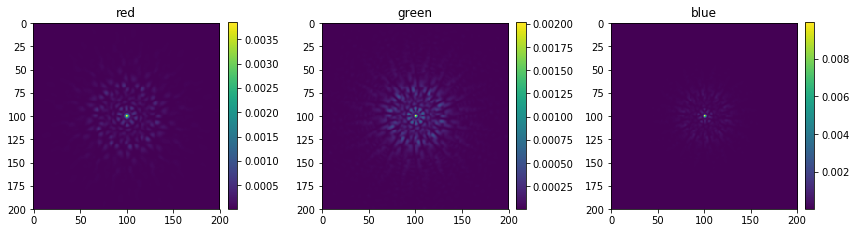

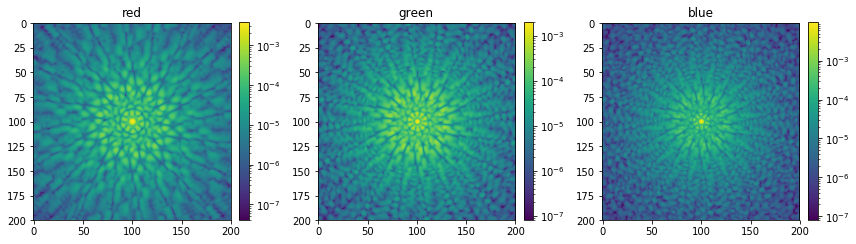

In [29]:
size = 200
fig1, axs1 = plt.subplots(1, 3, figsize=(12, 4))
fig2, axs2 = plt.subplots(1, 3, figsize=(12, 4))
for image,colour,ax1,ax2 in zip(RGB_images,colours,axs1,axs2):
    c = image.shape[0]/2
    im_out = image[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
    im_out = im_out/np.sum(im_out)
    
    im = ax1.imshow(im_out)
    ax1.set_title(colour)
    plt.colorbar(im,ax=ax1,fraction=0.046, pad=0.04)
    
    
    im = ax2.imshow(im_out,norm=LogNorm())
    ax2.set_title(colour)
    plt.colorbar(im,ax=ax2,fraction=0.046, pad=0.04)

fig1.tight_layout()
# fig1.savefig(image_path + "wavels_grouped.jpg", bbox_inches='tight')


fig2.tight_layout()
# fig2.savefig(image_path + "wavels_LogNorm_grouped.jpg", bbox_inches='tight')


#### Comapre to FT

In [30]:
%%time

tinytol_settings['get_wf'] = True
tinytol_settings['beam_ratio'] = 0.99
wfo, wf, sampling = prescription_quad(wl_vals[0]*1e-6,gridsize,PASSVALUE=tinytol_settings)
tinytol_settings['get_wf'] = False
tinytol_settings['beam_ratio'] = ratio

mask = wf
mask_size = tinytol_settings['diam']
chip_dim = npixels
foc_length = tinytol_settings['m1_fl']
pix_size = detector_pitch

# samples = 15
samples = 3
colours = ["red","green","blue"]


FT_red = model_FT(mask, mask_size, chip_dim, get_spec("MizarA", "red", samples)[0][0], foc_length, pix_size)
FT_green = model_FT(mask, mask_size, chip_dim, get_spec("MizarA", "green", samples)[0][0], foc_length, pix_size)
FT_blue = model_FT(mask, mask_size, chip_dim, get_spec("MizarA", "blue", samples)[0][0], foc_length, pix_size)

FT_RGB_images = [FT_red, FT_green, FT_blue]

Got wavefront
CPU times: user 1min 1s, sys: 11.1 s, total: 1min 13s
Wall time: 52.7 s


In [31]:
# FT_RGB_images = [FT_red, FT_green, FT_blue]
# size = 200

# for image,colour in zip(FT_RGB_images,colours):    
#     c = image.shape[0]/2
#     im_out = image[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
#     im_out = im_out/np.sum(im_out)
    
#     plt.imshow(im_out)
#     plt.colorbar()
#     plt.savefig(image_path + "wavels_FT_" + colour + ".jpg", bbox_inches='tight')
#     plt.show()
    
#     plt.imshow(im_out,norm=LogNorm())
#     plt.colorbar()
#     plt.savefig(image_path + "wavels_FT_Lognorm_" + colour + ".jpg", bbox_inches='tight')
#     plt.show()

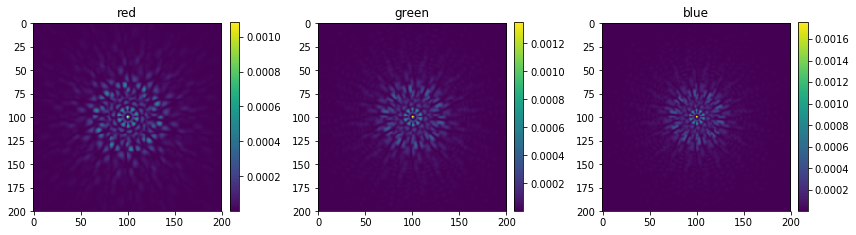

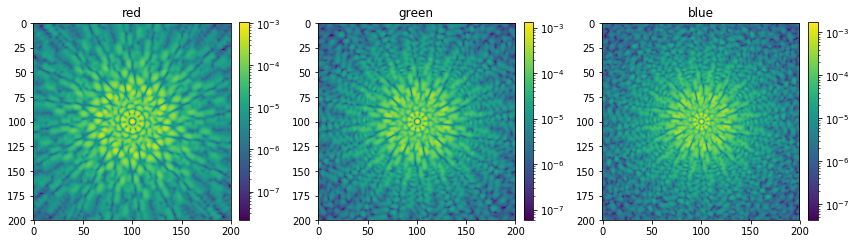

In [32]:
size = 200
fig1, axs1 = plt.subplots(1, 3, figsize=(12, 4))
fig2, axs2 = plt.subplots(1, 3, figsize=(12, 4))

for image,colour,ax1,ax2 in zip(FT_RGB_images,colours,axs1,axs2):
    c = image.shape[0]/2
    im_out = image[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
    im_out = im_out/np.sum(im_out)
    
    im = ax1.imshow(im_out)
    ax1.set_title(colour)
    plt.colorbar(im,ax=ax1,fraction=0.046, pad=0.04)
    
    im = ax2.imshow(im_out,norm=LogNorm())
    ax2.set_title(colour)
    plt.colorbar(im,ax=ax2,fraction=0.046, pad=0.04)

fig1.tight_layout()
# fig1.savefig(image_path + "wavels_FT_grouped.jpg", bbox_inches='tight')


fig2.tight_layout()
# fig2.savefig(image_path + "wavels_FT_LogNorm_grouped.jpg", bbox_inches='tight')


#### Get individual RGB channels from each formed image from Bayer pattern

In [63]:
Bayer_images = []
FT_Bayer_images = []

for i in range(len(colours)):
    colour = colours[i]
    
    # Normalise then interpolate
    im = RGB_images[i]/np.sum(RGB_images[i])
    im_FT = FT_RGB_images[i]/np.sum(FT_RGB_images[i])
    
    if colour == "red":
        im_out = get_red(im)
        im_out_FT = get_red(im_FT)
        
    elif colour == "green":
        im_out = get_green(im)
        im_out_FT = get_green(im_FT)

    elif colour == "blue":
        im_out = get_blue(im)
        im_out_FT = get_blue(im_FT)

    Bayer_images.append(im_out)
    FT_Bayer_images.append(im_out_FT)

In [64]:
# # size = 50

# for image,colour in zip(RGB_images,colours):    
#     c = image.shape[0]/2
#     im_out = image[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
    
#     plt.imshow(im_out)
#     plt.colorbar()
#     plt.savefig(image_path + "wavels_bayer_" + colour + ".jpg", bbox_inches='tight')
#     plt.show()

#     plt.imshow(im_out,norm=LogNorm())
#     plt.colorbar()
#     plt.savefig(image_path + "wavels_bayer_Lognorm_" + colour + ".jpg", bbox_inches='tight')
#     plt.show()



#### Compare to FT

In [65]:
# # size = 100

# for image,colour in zip(FT_RGB_images,colours):    
#     c = image.shape[0]/2
#     im_out = image[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
    
#     plt.imshow(im_out)
#     plt.colorbar()
#     plt.savefig(image_path + "wavels_bayer_FT_" + colour + ".jpg", bbox_inches='tight')
#     plt.show()

    
#     plt.imshow(im_out,norm=LogNorm())
#     plt.colorbar()
#     plt.savefig(image_path + "wavels_bayer_FT_Lognorm_" + colour + ".jpg", bbox_inches='tight')

#     plt.show()

#### Now use count rates to get expected counts per frame for a given magnitude star

In [66]:
colours = ["red","green","blue"]
stars = ["MizarA"]
bands = ["575-650", "475-600","400-525"]
fps = 10
# size = 50

Bayer_images_counts = []
FT_Bayer_images_counts = []

for i in range(len(colours)):
    image = Bayer_images[i]
    image_FT = FT_Bayer_images[i]
    colour = colours[i]
    band = bands[i]
    
    counts = get_counts(stars,colour,fps)
    print("{:.0f} counts per frame in the {} band {}nm".format(counts,colour,band))
        
    im_out = counts*image
    im_out_FT = counts*image_FT
        
    Bayer_images_counts.append(im_out)
    FT_Bayer_images_counts.append(im_out_FT)

24037 counts per frame in the red band 575-650nm
51448 counts per frame in the green band 475-600nm
66742 counts per frame in the blue band 400-525nm


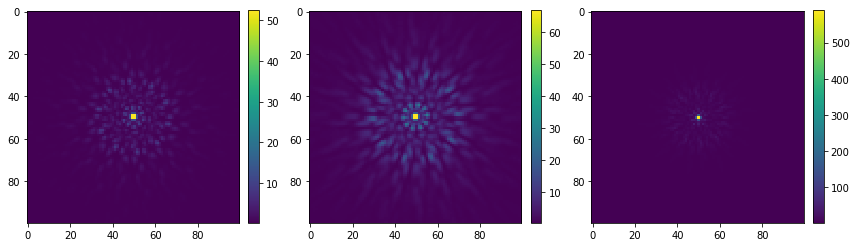

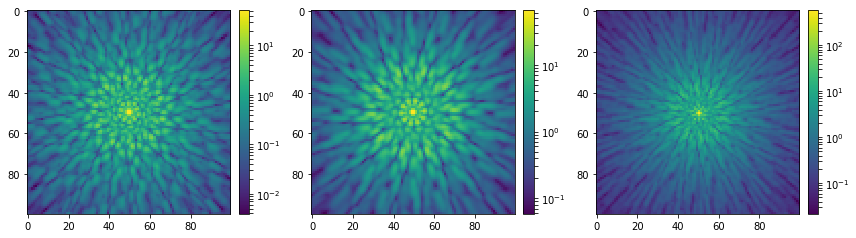

In [67]:
size = 100
fig1, axs1 = plt.subplots(1, 3, figsize=(12, 4))
fig2, axs2 = plt.subplots(1, 3, figsize=(12, 4))

for image,colour,ax1,ax2 in zip(Bayer_images_counts,colours,axs1,axs2):
    c = image.shape[0]/2
    im_out = image[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
    
    im = ax1.imshow(im_out)
    plt.colorbar(im,ax=ax1,fraction=0.046, pad=0.04)
    
    im = ax2.imshow(im_out,norm=LogNorm())
    plt.colorbar(im,ax=ax2,fraction=0.046, pad=0.04)

fig1.tight_layout()
# fig1.savefig(image_path + "wavels_bayer_counts_grouped.jpg", bbox_inches='tight')

fig2.tight_layout()
# fig2.savefig(image_path + "wavels_bayer_counts_LogNorm_grouped.jpg", bbox_inches='tight')

#### Now compare to FT

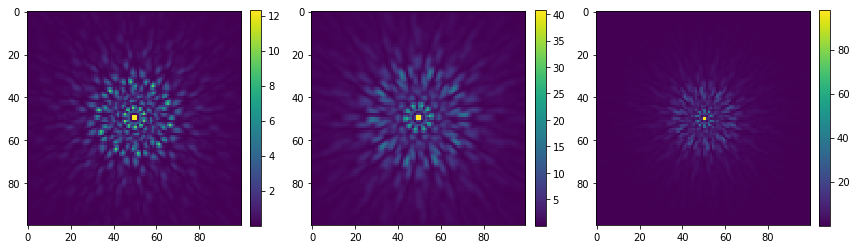

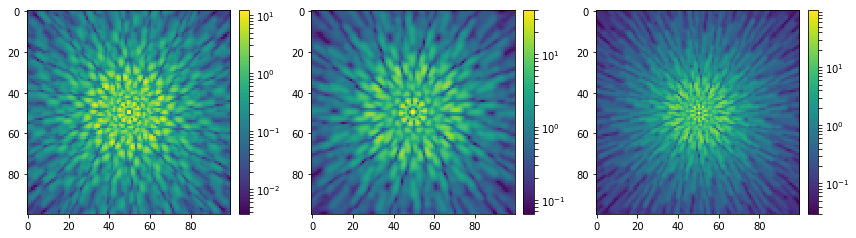

In [68]:
size = 100
fig1, axs1 = plt.subplots(1, 3, figsize=(12, 4))
fig2, axs2 = plt.subplots(1, 3, figsize=(12, 4))

for image,colour,ax1,ax2 in zip(FT_Bayer_images_counts,colours,axs1,axs2):
    c = image.shape[0]/2
    im_out = image[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
    
    im = ax1.imshow(im_out)
    plt.colorbar(im,ax=ax1,fraction=0.046, pad=0.04)
    
    im = ax2.imshow(im_out,norm=LogNorm())
    plt.colorbar(im,ax=ax2,fraction=0.046, pad=0.04)

fig1.tight_layout()
# fig1.savefig(image_path + "wavels_bayer_counts_FT_grouped.jpg", bbox_inches='tight')


fig2.tight_layout()
# fig2.savefig(image_path + "wavels_bayer_counts_LogNorm_FT_grouped.jpg", bbox_inches='tight')


#### From here we can simulate star fields through the Tinytol system!

#### Ursae Majoris system

In [84]:
MizarA = {
        'diam': app,                              # telescope diameter in meters
        'm1_fl': fl,                              # primary focal length (m)
        'beam_ratio': ratio,                      # Initial beam width/grid width
        'tilt_x': -7.00,                          # Tilt angle along x (arc seconds)
        'tilt_y': -0.00,                          # Tilt angle along y (arc seconds)
        'opd_func': spiral,                       # Phase pupil function
        }   

MizarB = {
        'diam': app,                              # telescope diameter in meters
        'm1_fl': fl,                              # primary focal length (m)
        'beam_ratio': ratio,                      # Initial beam width/grid width
        'tilt_x': +7.00,                          # Tilt angle along x (arc seconds)
        'tilt_y': -0.00,                          # Tilt angle along y (arc seconds)
        'opd_func': spiral,                       # Phase pupil function
        }   

Alcor = {
        'diam': app,                              # telescope diameter in meters
        'm1_fl': fl,                              # primary focal length (m)
        'beam_ratio': ratio,                      # Initial beam width/grid width
        'tilt_x': -500.,                          # Tilt angle along x (arc seconds)
        'tilt_y': -500.,                          # Tilt angle along y (arc seconds)
        'opd_func': spiral,                       # Phase pupil function
        } 

source_settings = [MizarA, MizarB, Alcor]

In [85]:
%%time

samples = 5
stars = ["MizarA","MizarB","Alcor"]
colours = ["red","green","blue"]
U_images = []

gridsize = 4096
npixels = 2048

for colour in colours:
    sources = []
    counts = 0
    
    for i in range(len(source_settings)):
        spec = get_spec(stars[i], colour, samples, microns=True)
        source = {
                'wavelengths': spec[0][0],
                'weights': spec[0][1],
                'settings': source_settings[i],
                }
        sources.append(source)

        counts += get_counts(stars[i],colour,fps=10)

    im = form_detector_image(prescription, sources, gridsize, detector_pitch, npixels)
    
    norm_im = im/np.sum(im)
    im = counts*norm_im
    
    print("{}: {:.0f} counts per frame".format(colour, counts))
    
    if colour == "red":
        im_out = get_red(im)
    elif colour == "green":
        im_out = get_green(im)
    elif colour == "blue":
        im_out = get_blue(im)
        
    U_images.append(im_out)

red: 33961 counts per frame
green: 72689 counts per frame
blue: 94298 counts per frame
CPU times: user 3min 38s, sys: 1min 18s, total: 4min 56s
Wall time: 17min 7s


##### Display images

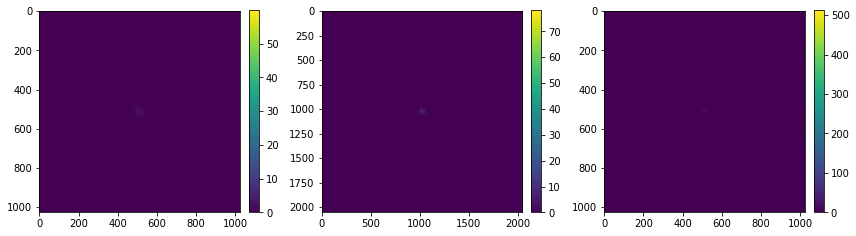

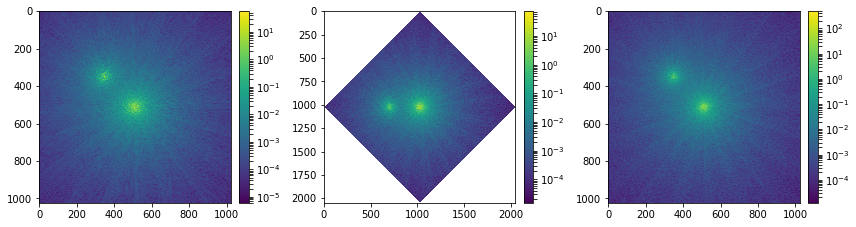

In [86]:
fig1, axs1 = plt.subplots(1, 3, figsize=(12, 4))
fig2, axs2 = plt.subplots(1, 3, figsize=(12, 4))

for image,colour,ax1,ax2 in zip(U_images,colours,axs1,axs2):
    im_out = image
    
    im = ax1.imshow(im_out)
    plt.colorbar(im,ax=ax1,fraction=0.046, pad=0.04)
    
    im = ax2.imshow(im_out,norm=LogNorm())
    plt.colorbar(im,ax=ax2,fraction=0.046, pad=0.04)

fig1.tight_layout()
# fig1.savefig(image_path + "Ursae_bayer_counts_grouped.jpg", bbox_inches='tight')


fig2.tight_layout()
# fig2.savefig(image_path + "Ursae_bayer_counts_LogNorm_grouped.jpg", bbox_inches='tight')

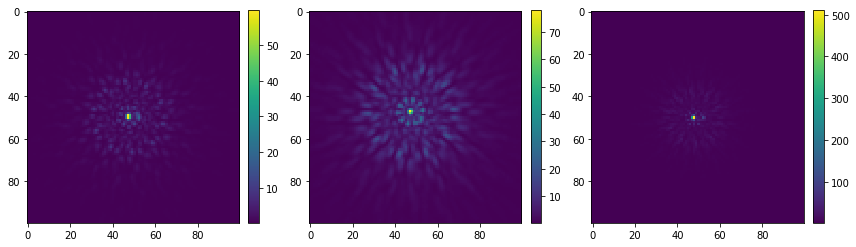

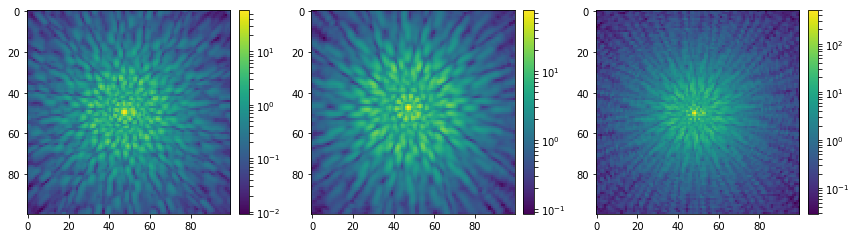

In [87]:
size = 100

fig1, axs1 = plt.subplots(1, 3, figsize=(12, 4))
fig2, axs2 = plt.subplots(1, 3, figsize=(12, 4))

for image,colour,ax1,ax2 in zip(U_images,colours,axs1,axs2):
    c = image.shape[0]/2
    im_out = image[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
    
    im = ax1.imshow(im_out)
    plt.colorbar(im,ax=ax1,fraction=0.046, pad=0.04)
    
    im = ax2.imshow(im_out,norm=LogNorm())
    plt.colorbar(im,ax=ax2,fraction=0.046, pad=0.04)

fig1.tight_layout()
# fig1.savefig(image_path + "Ursae_bayer_counts_central_grouped.jpg", bbox_inches='tight')


fig2.tight_layout()
# fig2.savefig(image_path + "Ursae_bayer_counts_central_LogNorm_grouped.jpg", bbox_inches='tight')

#### Now model boradband pupil with FT's

In [88]:
%%time

mask_size = tinytol_settings['diam']
chip_dim = npixels
foc_length = tinytol_settings['m1_fl']
pix_size = detector_pitch

samples = 5
# stars = ["MizarA", "MizarB", "Alcor"]
# colours = ["red", "green", "blue"]

U_images_FT = []
for colour in colours:
    counts = 0
    image = np.zeros((chip_dim,chip_dim))
    
    for star,setting in zip(stars, source_settings):
        counts += get_counts(star,colour,fps=10)
        spec = get_spec(star, colour, samples=5, microns=True)
        wavelengths = spec[0][0]
        
        for wavelength in wavelengths:
            wf = get_wf(wavelength*1e-6,gridsize,PASSVALUE=setting)
            image += model_FT(wf, mask_size, chip_dim, [wavelength*1e-6], foc_length, pix_size)
    
    norm_im = image/np.sum(image)
    im = counts*norm_im
    
    if colour == "red":
        im_out = get_red(im)
    elif colour == "green":
        im_out = get_green(im)
    elif colour == "blue":
        im_out = get_blue(im)
        
    U_images_FT.append(im_out)

Process ForkPoolWorker-90:
Process ForkPoolWorker-87:
Process ForkPoolWorker-88:
Process ForkPoolWorker-91:
Process ForkPoolWorker-93:
Process ForkPoolWorker-89:
Process ForkPoolWorker-92:
Process ForkPoolWorker-94:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/louis/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/louis/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/louis/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/louis/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/louis/anaconda3/lib/python3.6/multipr

KeyboardInterrupt: 

Process ForkPoolWorker-96:
Process ForkPoolWorker-101:
Process ForkPoolWorker-97:
Process ForkPoolWorker-100:
Process ForkPoolWorker-99:
Process ForkPoolWorker-98:
Process ForkPoolWorker-95:
Process ForkPoolWorker-102:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/louis/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/louis/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/louis/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/louis/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/louis/anaconda3/lib/python3.6/mult

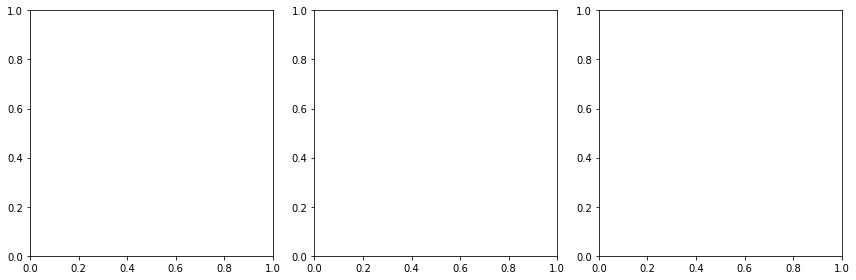

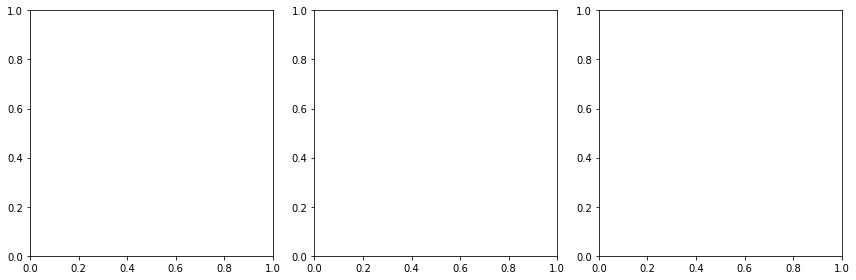

In [89]:
fig1, axs1 = plt.subplots(1, 3, figsize=(12, 4))
fig2, axs2 = plt.subplots(1, 3, figsize=(12, 4))

for image,colour,ax1,ax2 in zip(U_images_FT,colours,axs1,axs2):
    im_out = image
    
    im = ax1.imshow(im_out)
    plt.colorbar(im,ax=ax1,fraction=0.046, pad=0.04)
    
    im = ax2.imshow(im_out,norm=LogNorm())
    plt.colorbar(im,ax=ax2,fraction=0.046, pad=0.04)

fig1.tight_layout()
# fig1.savefig(image_path + "Ursae_bayer_counts_FT_grouped.jpg", bbox_inches='tight')

fig2.tight_layout()
# fig2.savefig(image_path + "Ursae_bayer_counts_FT_LogNorm_grouped.jpg", bbox_inches='tight')

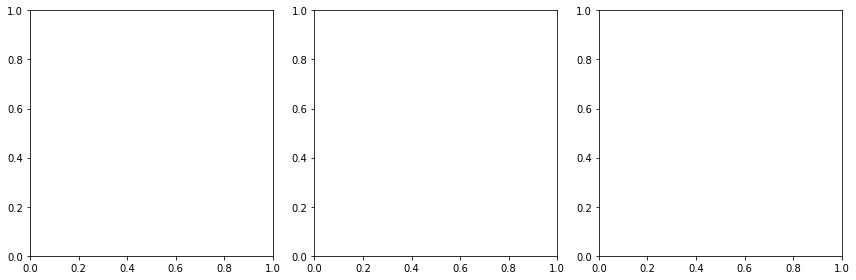

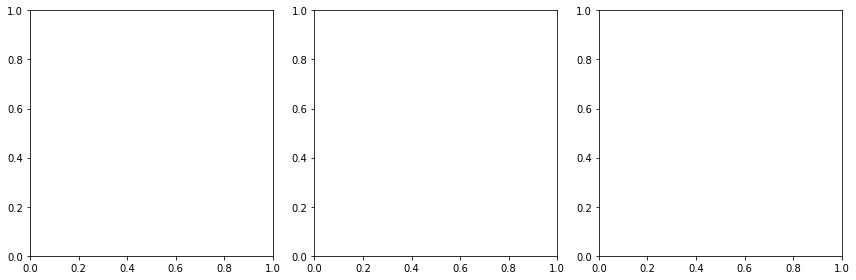

In [90]:
size = 150
fig1, axs1 = plt.subplots(1, 3, figsize=(12, 4))
fig2, axs2 = plt.subplots(1, 3, figsize=(12, 4))

for image,colour,ax1,ax2 in zip(U_images_FT,colours,axs1,axs2):
    c = image.shape[0]/2
    im_out = image[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
    im_out = im_out/np.sum(im_out)
    
    im = ax1.imshow(im_out)
    plt.colorbar(im,ax=ax1,fraction=0.046, pad=0.04)
    
    im = ax2.imshow(im_out,norm=LogNorm())
    plt.colorbar(im,ax=ax2,fraction=0.046, pad=0.04)

fig1.tight_layout()
# fig1.savefig(image_path + "Ursae_bayer_counts_FT_central_grouped.jpg", bbox_inches='tight')


fig2.tight_layout()
# fig2.savefig(image_path + "Ursae_bayer_counts_FT_central_LogNorm_grouped.jpg", bbox_inches='tight')


### Pleiades system

In [91]:
t_25 = SkyCoord('3h47m29.01s','24deg06m18.50s')
t_27 = SkyCoord('3h49m09.74s','24deg03m12.30s')
t_17 = SkyCoord('3h44m52.54s','24deg06m48.01s')
t_20 = SkyCoord('3h45m49.61s','24deg22m03.90s')
t_23 = SkyCoord('3h46m19.57s','23deg56m54.08s')
t_19 = SkyCoord('3h45m12.50s','24deg28m02.21s')
t_28 = SkyCoord('3h49m11.22s','24deg08m12.16s')

cen = SkyCoord('3h46m30.00s','24deg12m0.00s')
# cen = SkyCoord('3h47m29.01s','24deg06m18.50s')

# cen = SkyCoord('3h45m00.00s','24deg12m0.00s')

separations = []
separations.append(cen.spherical_offsets_to(t_25))
separations.append(cen.spherical_offsets_to(t_27))
separations.append(cen.spherical_offsets_to(t_17))
separations.append(cen.spherical_offsets_to(t_20))
separations.append(cen.spherical_offsets_to(t_23))
separations.append(cen.spherical_offsets_to(t_19))
separations.append(cen.spherical_offsets_to(t_28))

In [92]:
T_25 = {
        'diam': app,                             # telescope diameter in meters
        'm1_fl': fl,                             # primary focal length (m)
        'beam_ratio': ratio,                     # Initial beam width/grid width
        'opd_func': spiral,                      # Phase pupil function
        }   

T_27 = {
        'diam': app,                             # telescope diameter in meters
        'm1_fl': fl,                             # primary focal length (m)
        'beam_ratio': ratio,                     # Initial beam width/grid width
        'opd_func': spiral,                      # Phase pupil function
        }   

T_17 = {
        'diam': app,                             # telescope diameter in meters
        'm1_fl': fl,                             # primary focal length (m)
        'beam_ratio': ratio,                     # Initial beam width/grid width
        'opd_func': spiral,                      # Phase pupil function
        }  

T_20 = {
        'diam': app,                             # telescope diameter in meters
        'm1_fl': fl,                             # primary focal length (m)
        'beam_ratio': ratio,                     # Initial beam width/grid width
        'opd_func': spiral,                      # Phase pupil function
        }  

T_23 = {
        'diam': app,                             # telescope diameter in meters
        'm1_fl': fl,                             # primary focal length (m)
        'beam_ratio': ratio,                     # Initial beam width/grid width
        'opd_func': spiral,                      # Phase pupil function
        }  

T_19 = {
        'diam': app,                             # telescope diameter in meters
        'm1_fl': fl,                             # primary focal length (m)
        'beam_ratio': ratio,                     # Initial beam width/grid width
        'opd_func': spiral,                      # Phase pupil function
        }   

T_28 = {
        'diam': app,                             # telescope diameter in meters
        'm1_fl': fl,                             # primary focal length (m)
        'beam_ratio': ratio,                     # Initial beam width/grid width
        'opd_func': spiral,                      # Phase pupil function
        }   

source_settings = [T_25, T_27, T_17, T_20, T_23, T_19, T_28]

In [93]:
for setting,sep in zip(source_settings,separations):
    setting['tilt_x'] = sep[0].arcsec
    setting['tilt_y'] = sep[1].arcsec

In [94]:
gridsize = 4096
npixels = 2048

In [95]:
%%time

samples = 5
stars = ["Tauri_25", "Tauri_27", "Tauri_17", "Tauri_20", "Tauri_23", "Tauri_19","Tauri_28"]
colours = ["red", "green", "blue"]
P_images = []

for colour in colours:
    sources = []
    for i in range(len(source_settings)):
        counts += get_counts(stars[i],colour,fps=10)
        spec = get_spec(stars[i], colour, samples, microns=True)
        source = {
                'wavelengths': spec[0][0],
                'weights': spec[0][1],
                'settings': source_settings[i],
                }
        sources.append(source)
        
    image = form_detector_image(prescription, sources, gridsize, detector_pitch, npixels)
    
    norm_im = image/np.sum(image)
    im = counts*norm_im    
    
    if colour == "red":
        im_out = get_red(im)
    elif colour == "green":
        im_out = get_green(im)
    elif colour == "blue":
        im_out = get_blue(im)
    P_images.append(im_out)

KeyboardInterrupt: 

Process ForkPoolWorker-103:
Traceback (most recent call last):
  File "/Users/louis/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/louis/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/louis/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/Users/louis/anaconda3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Users/louis/.local/lib/python3.6/site-packages/PyPROPER3-1.0.0-py3.6-macosx-10.7-x86_64.egg/proper/prop_execute_multi.py", line 36, in prop_execute_multi
    psf, sampling = proper.prop_run(routine_name, lamda, gridsize, PASSVALUE = passvalue, QUIET = quiet, PHASE_OFFSET = phase_offset)
  File "/Users/louis/.local/lib/python3.6/site-packages/PyPROPER3-1.0.0-py3.6-macosx-10.7-x86_64.egg/proper/prop_run.py", line 137, in prop_

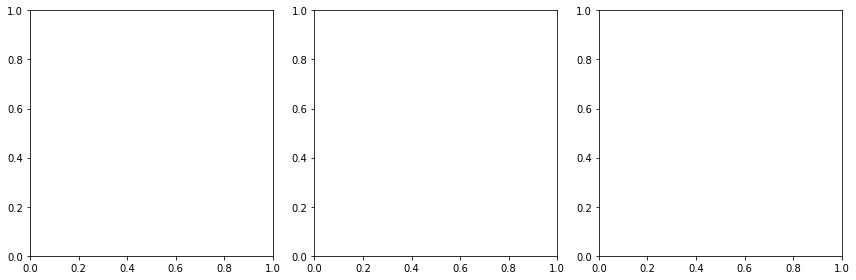

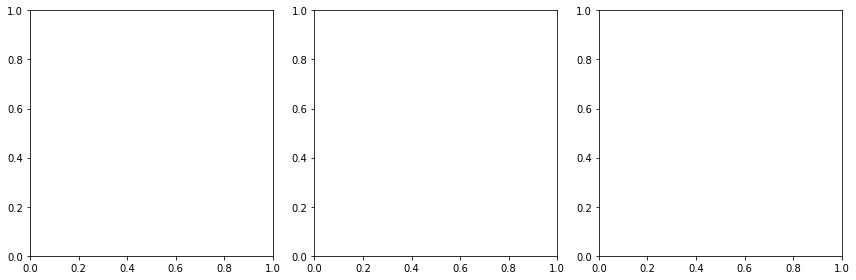

Process ForkPoolWorker-115:
Process ForkPoolWorker-117:
Process ForkPoolWorker-114:
Process ForkPoolWorker-113:
Process ForkPoolWorker-110:
Process ForkPoolWorker-107:
Process ForkPoolWorker-112:
Process ForkPoolWorker-108:
Process ForkPoolWorker-111:
Process ForkPoolWorker-118:
Process ForkPoolWorker-116:
Process ForkPoolWorker-109:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/louis/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/louis/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/lou

In [96]:
fig1, axs1 = plt.subplots(1, 3, figsize=(12, 4))
fig2, axs2 = plt.subplots(1, 3, figsize=(12, 4))

for image,colour,ax1,ax2 in zip(P_images,colours,axs1,axs2):
    im_out = image
    
    im = ax1.imshow(im_out)
    plt.colorbar(im,ax=ax1,fraction=0.046, pad=0.04)
    
    im = ax2.imshow(im_out,norm=LogNorm())
    plt.colorbar(im,ax=ax2,fraction=0.046, pad=0.04)

fig1.tight_layout()
# fig1.savefig(image_path + "Pleiades_bayer_counts_grouped.jpg", bbox_inches='tight')

fig2.tight_layout()
# fig2.savefig(image_path + "Pleiades_bayer_counts_LogNorm_grouped.jpg", bbox_inches='tight')

### Now model broadband pupil with FT's

In [97]:
%%time

mask_size = tinytol_settings['diam']
chip_dim = npixels
foc_length = tinytol_settings['m1_fl']
pix_size = detector_pitch
# samples = 5

P_images_FT = []
for colour in colours:
    counts = 0
    image = np.zeros((chip_dim,chip_dim))
    
    for star,setting in zip(stars, source_settings):
        counts += get_counts(star,colour,fps=10)
        spec = get_spec(star, colour, samples=5, microns=True)
        wavelengths = spec[0][0]
        
        for wavelength in wavelengths:
            wf = get_wf(wavelength*1e-6,gridsize,PASSVALUE=setting)
            image += model_FT(wf, mask_size, chip_dim, [wavelength*1e-6], foc_length, pix_size)
    
    norm_im = image/np.sum(image)
    im = counts*norm_im
    
    if colour == "red":
        im_out = get_red(im)
    elif colour == "green":
        im_out = get_green(im)
    elif colour == "blue":
        im_out = get_blue(im)
        
    P_images_FT.append(im_out)

KeyboardInterrupt: 

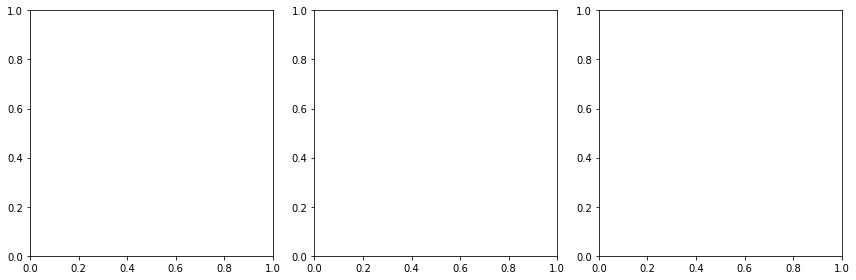

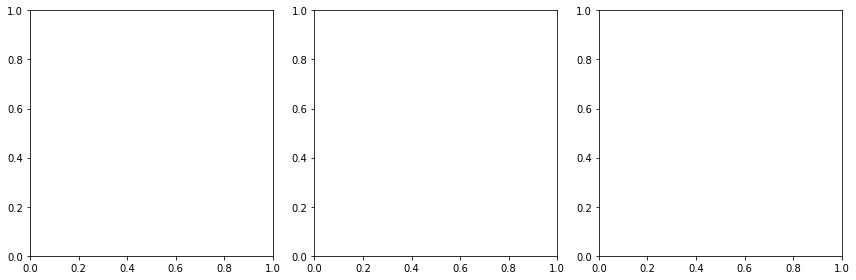

In [98]:
fig1, axs1 = plt.subplots(1, 3, figsize=(12, 4))
fig2, axs2 = plt.subplots(1, 3, figsize=(12, 4))

for image,colour,ax1,ax2 in zip(P_images_FT,colours,axs1,axs2):
    im_out = image
    
    im = ax1.imshow(im_out)
    plt.colorbar(im,ax=ax1,fraction=0.046, pad=0.04)
    
    im = ax2.imshow(im_out,norm=LogNorm())
    plt.colorbar(im,ax=ax2,fraction=0.046, pad=0.04)

fig1.tight_layout()
# fig1.savefig(image_path + "Pleiades_bayer_counts_FT_grouped.jpg", bbox_inches='tight')


fig2.tight_layout()
# fig2.savefig(image_path + "Pleides_bayer_counts_FT_LogNorm_grouped.jpg", bbox_inches='tight')    